In [2]:
import dotenv
from matplotlib import animation
from matplotlib import pyplot as plt
from mplsoccer import Pitch
import numpy as np
import os
import pandas as pd
print("Modules imported.")

Modules imported.


## Querying the database

Import the environment file .env with the credentials to get access to the database.<br>
⚠️ WARNING: This requires the .env file in the same directory as this notebook!

In [3]:
dotenv.load_dotenv()

## Those parameters are stored in the .env file.
PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_USER = os.getenv("PG_USER")
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DATABASE = os.getenv("PG_DATABASE")
print("Credentials imported from .env file.")

Credentials imported from .env file.


Prepare the connection parameters to send a query to the database.

In [4]:
import psycopg2
import os

conn = psycopg2.connect(
    host=PG_HOST,
    database=PG_DATABASE,
    user=PG_USER,
    password=PG_PASSWORD,
    port=PG_PORT,
    sslmode="require",
)
print("Connection parameters ready.")

Connection parameters ready.


The query that will be sent to the database.

In [5]:
query = """
    SELECT pt.frame_id, pt.timestamp, pt.player_id, pt.x, pt.y, p.jersey_number, p.player_name, p.team_id
    FROM player_tracking pt
    JOIN players p ON pt.player_id = p.player_id
    JOIN teams t ON p.team_id = t.team_id
    WHERE pt.game_id = '5uts2s7fl98clqz8uymaazehg';
"""
print("Query ready.")

Query ready.


Perform the query and store its answer into a dataframe.

In [6]:
print("Querying the database. This may take a while...")
tracking_df = pd.read_sql_query(query, conn)
print(f"Received dataframe:\n{tracking_df.head()}\n")

Querying the database. This may take a while...
Received dataframe:
        frame_id timestamp                  player_id          x          y  \
0  1722799204000  00:05:04   pi2sxs616a52jvpfywgwjowl  46.591803  82.008591   
1  1722799204000  00:05:04  60gs7lod7de72ypcs6qfup8q2  53.204590  50.845902   
2  1722799204000  00:05:04  3r04y1fejoh9e8qbge3exy3u1  21.321672   2.013952   
3  1722799204000  00:05:04  dxcsuw39xzusjsj5e1jw53y6t  77.095147  49.095082   
4  1722799204000  00:05:04  863wevd1kdzq5sd7qpmhr4lqs  30.326181  13.390267   

   jersey_number    player_name                    team_id  
0             22     G. Ruyssen  4dtif7outbuivua8umbwegoo5  
1              9  A. Guðjohnsen  8y3iucyxguipljcmf87a11bk9  
2             22      N. Fadiga  8y3iucyxguipljcmf87a11bk9  
3             34     M. Verrips  4dtif7outbuivua8umbwegoo5  
4             88     F. Ferraro  4dtif7outbuivua8umbwegoo5  



Split the received data between different dataframes: One for the ball, one for the home team and one for the away team.

In [7]:
print("Splitting up data...")
home_team_id = "8y3iucyxguipljcmf87a11bk9"
away_team_id = "4dtif7outbuivua8umbwegoo5"
ball_team_id = "1oyb7oym5nwzny8vxf03szd2h"

df_home = tracking_df[tracking_df['team_id'] == home_team_id]
df_away = tracking_df[tracking_df['team_id'] == away_team_id]
df_ball = tracking_df[tracking_df['team_id'] == ball_team_id]

# Print the first few rows to verify
print(f"Home team data:\n{df_home.head()}")
print(f"Away team data:\n{df_away.head()}")
print(f"Ball team data:\n{df_ball.head()}\n")

Splitting up data...
Home team data:
         frame_id timestamp                  player_id          x          y  \
1   1722799204000  00:05:04  60gs7lod7de72ypcs6qfup8q2  53.204590  50.845902   
2   1722799204000  00:05:04  3r04y1fejoh9e8qbge3exy3u1  21.321672   2.013952   
5   1722799204000  00:05:04  18pgjfpl9s8qy32mblzygsyc5  37.666707  68.047018   
6   1722799204000  00:05:04  7ld784sfqk29tlvpes2f4vcru  33.100966  10.505788   
10  1722799204000  00:05:04  8kz0e83d3azssd7unbk2lqt0q  21.883733  91.569147   

    jersey_number    player_name                    team_id  
1               9  A. Guðjohnsen  8y3iucyxguipljcmf87a11bk9  
2              22      N. Fadiga  8y3iucyxguipljcmf87a11bk9  
5              24        S. Kums  8y3iucyxguipljcmf87a11bk9  
6              14      D. Yokota  8y3iucyxguipljcmf87a11bk9  
10              3       A. Brown  8y3iucyxguipljcmf87a11bk9  
Away team data:
        frame_id timestamp                  player_id          x          y  \
0  172279920400

## Animation

Set up the figure and its axis.

Figure and axis set up.


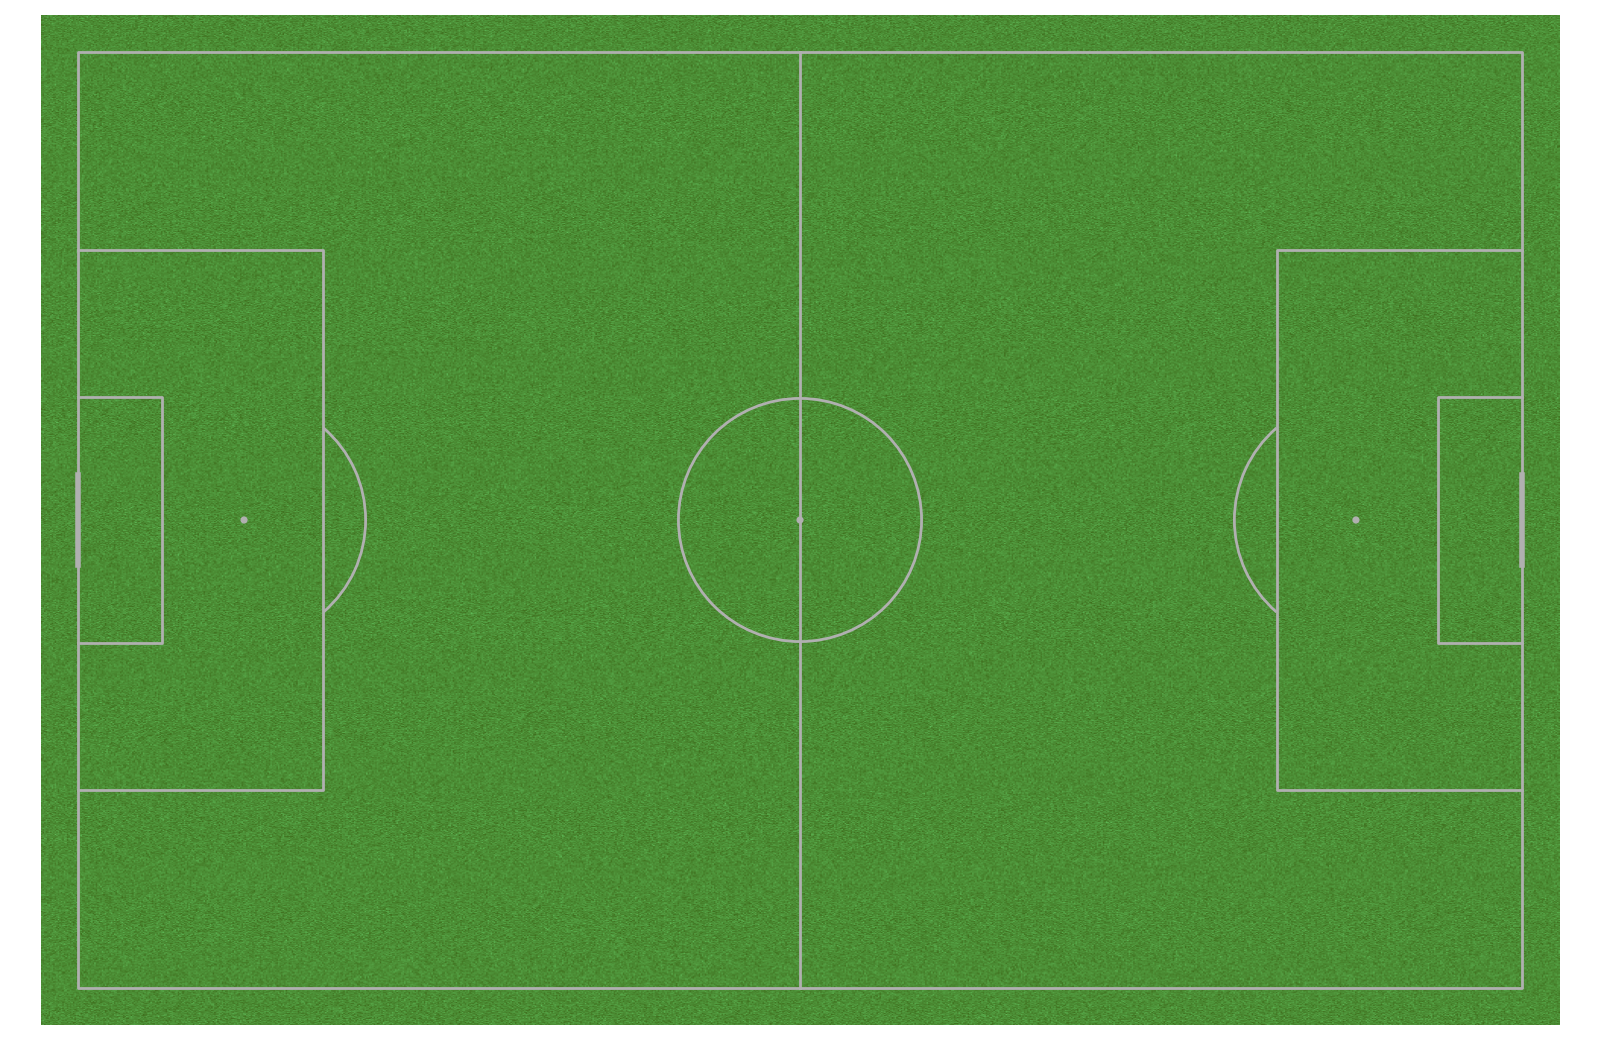

In [8]:
pitch = Pitch(pitch_type='opta', goal_type='line', pitch_color='grass',
                pitch_width=68, pitch_length=105)
fig, ax = pitch.draw(figsize=(16, 10.4))
print("Figure and axis set up.")

Plot the markers that will be shown on the figure and initiate a variable text_objects that will reference the name of the players displayed on a frame, then be cleared for the next one.

In [9]:
marker_kwargs = {'marker': 'o', 'markeredgecolor': 'black', 'linestyle': 'None'}
ball, = ax.plot([], [], ms=10, markerfacecolor='#ffce00', zorder=3, **marker_kwargs) # yellow
away, = ax.plot([], [], ms=10, markerfacecolor='#ff0000', **marker_kwargs)  # red
home, = ax.plot([], [], ms=10, markerfacecolor='#008cff', **marker_kwargs)  # blue

text_objects = []
print("Markers set up.\ntext_objects variable initiated.")

Markers set up.
text_objects variable initiated.


The animation function: It will be called everytime a frame needs to be generated.

In [10]:
def animate(i):
    """ Function to animate the data. Each frame it sets the data for the players and the ball."""
    for text in text_objects:
        text.remove()  # Remove the old text objects
    text_objects.clear()  # Clear the list to prepare for new text objects
    timestamp = df_ball.iloc[i, 1]
    # set the ball data with the x and y positions for the ith frame
    ball.set_data(df_ball.iloc[i, [3]], df_ball.iloc[i, [4]])
    # get the frame id for the ith frame
    frame = df_ball.iloc[i, 0]
    # set the player data using the frame id
    ## Loop through the 'away' team to plot each player's position and add their name

    # Collect x and y coordinates for all players at the current frame
    away_x = df_away.loc[df_away.frame_id == frame, 'x'].values
    away_y = df_away.loc[df_away.frame_id == frame, 'y'].values
    home_x = df_home.loc[df_home.frame_id == frame, 'x'].values
    home_y = df_home.loc[df_home.frame_id == frame, 'y'].values

    # Set the data for the away and home players using the sequences of x and y coordinates
    away.set_data(away_x, away_y)
    home.set_data(home_x, home_y)
    for _, row in df_away[df_away.frame_id == frame].iterrows():
        x = row['x']
        y = row['y']
        player_name = row['player_name']
        text = ax.text(x, y + 2, player_name, fontsize=8, ha='center', va='bottom', color='black')  # Add player name above the marker
        text_objects.append(text)  # Keep track of the text object
    ## Loop through the 'home' team to plot each player's position and add their name
    for _, row in df_home[df_home.frame_id == frame].iterrows():
        x = row['x']
        y = row['y']
        player_name = row['player_name']

        text = ax.text(x, y + 2, player_name, fontsize=8, ha='center', va='bottom', color='black')  # Add player name above the marker
        text_objects.append(text)  # Keep track of the text object
    
    ax.set_title(f'Player Positions at Event Timestamp: {timestamp}', fontsize=16)
    return ball, away, home
print("Animation function defined.")

Animation function defined.


Finally, the function that calls triggers the animation function a certain amount of times per second to generate frames.

In [11]:
print("Starting animation...\nThe animation will start on the previously rendered pitch at the section 'Set up the figure and its axis.'.")
anim = animation.FuncAnimation(fig, animate, frames=len(df_ball), interval=500, blit=False)

Starting animation...
The animation will start on the previously rendered pitch at the section 'Set up the figure and its axis.'.
